# Lecture 4 - Julia - Type Inference and Type Stability

- As you continue to master the core features of the Julia programming language, the next step is to understand how to write _performant_ Julia code.  


- Julia is usually highly efficient by default and requires little optimisation by the user. Most of the optimisation is done "under the hood" so you don't have to worry about it. 


- However, there are certain basic principles you should follow in order for your code to be fast. Accidentally or unknowingly violating these principles may lead to disappointing performance at runtime.


- The purpose of this lecture is to help you understand how and why Julia is fast, and therefore to help you avoid common pitfalls that may degrade the performance of your program. To get there, we'll take a very brief tour through computer architecture and programming languages.

## Contents
1. [Computers, CPUs, and Programming Languages](#computers)
2. [Julia is Dynamically Typed](#typing)
3. [Type Inference and Code Specialisation](#inference)
4. [Type Stability](#type-stability)
5. [Conclusion](#conclusion)
6. [Further Reading](#further-reading)

## 1. Computers, CPUs, and Programming Languages <a class="anchor" id="computers"></a>
- For most of us, the inner workings of a computer can seem mysterious. What actually happens when you execute your code?


    1. Write code in a text editor.
    2. Press play.
    3. ???
    4. Profit.


- Even a basic intuition for how a computer program works will help you to be a better programmer.


- At the very lowest level, your computer program consists of:
    1. A collection of binary numbers.
    2. A collection of _instructions_ describing a sequence of operations to be performed on those binary numbers.


- Those operations are performed by your computer's _central processing unit_ (CPU). A CPU is an electronic circuit which can do (very) basic arithmetic and logic on binary numbers. 


- A single instruction for the CPU could be something like: take the two floating-point numbers at memory locations A and B, add them, and store the result at memory location C.


- Scale this up to perform billions of instructions per second and you have a modern computer.


- CPU instructions are written in _machine code_. In Julia we can actually inspect the machine code of our programs!


In [1]:
@code_native binary=true 1+1  # Add two integers

	.text
; code origin: 00007f2813443f00, code size: 16
; ┌ @ int.jl:87 within `+`
; 3f00: 48 8d 04 37
	leaq	(%rdi,%rsi), %rax
; 3f04: c3
	retq
; 3f05: 66 2e 0f 1f 84 00 00 00 00 00
	nopw	%cs:(%rax,%rax)
; 3f0f: 90
	nop
; └


In [2]:
@code_native binary=true 1.0+1.0  # Add two floating-point numbers

	.text
; code origin: 00007f2813443a70, code size: 16
; ┌ @ float.jl:399 within `+`
; 3a70: c5 fb 58 c1
	vaddsd	%xmm1, %xmm0, %xmm0
; 3a74: c3
	retq
; 3a75: 66 2e 0f 1f 84 00 00 00 00 00
	nopw	%cs:(%rax,%rax)
; 3a7f: 90
	nop
; └


- Important: you do not need to understand what's going on above! But it's worth noting that the procedure for adding two numbers depends on the type of the numbers, even though both operations are mathematically equivalent.


- If you had to write out all of this binary machine code every time you wanted to add two numbers, writing even a moderately complex program would take a very long time indeed.


- That's why programming languages exist - to provide a human-friendly way of providing instructions to a computer.


- The challenge for a programming language, then, is to take high-level human-friendly code and find a way to translate it into equivalent low-level machine code which can be executed on a CPU.


- Traditionally, programming language implementations can be divided into two categories based on their choice of strategy for achieving this.

### 1.1. Compiled Programming Languages

- In a compiled programming language, source code is fully converted into executable machine code by a _compiler_. This step is known as _compile-time_.


- The result is a standalone machine code program, unintelligible to humans, which can then be executed. This execution step is known as _runtime_.


- This model is known as __ahead-of-time (AOT) compilation__.


- Examples of compiled languages commonly used in scientific computing include C, C++, and Fortran.

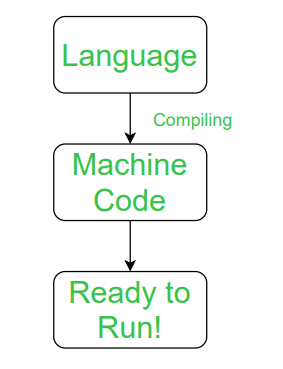

[Source](https://www.geeksforgeeks.org/difference-between-compiled-and-interpreted-language/)

### 1.2. Interpreted Programming Languages

- In an interpreted programming language, source code is continuously converted into machine code at runtime. 


- Effectively, an _interpreter_ steps through the source code line-by-line and sends machine code instructions to the CPU. 


- There is no compile-time in an interpreted language, only runtime.


- Examples of interpreted languages commonly used in scientific computing include Python, MATLAB, and R. 


- Interpreted languages are typically slower than compiled languages due to the overhead of the interpreter and the absence of optimisations which can be performed by the compiler.
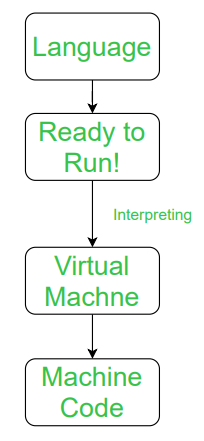

[Source](https://www.geeksforgeeks.org/difference-between-compiled-and-interpreted-language/)


### 1.3. Julia Is Just-In-Time (JIT) Compiled

- Just-in-time compiled languages combine aspects of both traditional ahead-of-time compiled languages and interpreted languages.


- At __runtime__, Julia first compiles your source code into native machine code, which is then executed on the CPU. 


- While this compilation step adds some initial runtime overhead, the resulting machine code is typically very fast.


- Wait, but what's the difference between JIT and AOT compilation?
    - JIT compilation occurs at runtime, which means that __runtime values and their types are available to the compiler__.
    - AOT compilation occurs before runtime, at compile-time, so runtime values are not available to the compiler.
    
    
- To fully appreciate this distinction, we need to talk about types again.

## 2. Julia Is Dynamically Typed <a class="anchor" id="typing"></a>

- In Julia, types are associated with _runtime values_ rather than variables.

In [3]:
a = 1.0  # a is a variable which is "bound" to the value (or object) 1.0
typeof(a)

Float64

- As a result, you are free to reassign a variable to an object of a different type at any point in your program.

In [4]:
a = "Julia"
typeof(a)

String

- This is what it means for Julia to be a __dynamically typed language__.


- The _variable_ `a` has no intrinsic type. It is simply a name associated with some object. Only the object to which it refers (now the string `"Hello"`) has a type.


- This behaviour is the same as Python, which is also dynamically typed.


- In contrast, in __statically typed languages__ such as C, C++, and Fortran, types are associated with _compile-time variables_.

In [ ]:
float a = 1.0;  # This is how you declare a single-precision floating-point number in C
a = "Hello";    # ERROR: Attempting to reassign the variable to a different type will result in an error

- Here, the type is associated with the variable `a` rather than the value `1.0`.


- What are the advantages of dynamic typing?  
    1. __Developer productivity__: code is quicker to write, since you don't have to declare and keep track of the types of all your variables.
    2. __Flexibility__: generic code can be written and reused for different types.
    
    
- What are the advantages of static typing?
    1. __Speed__: historically, statically typed languages were much more efficient due to the compiler optimisations made possible by the fact that variable types are fixed and known in advance.

## 3. Type Inference and Code Specialisation (or: Why Julia Is Fast)<a class="anchor" id="inference"></a>
- Historically, AOT compiled languages relied on static typing to enforce type constraints and therefore allow optimisations to be made by the compiler.


- __Julia's JIT compiler allows it to be both dynamically typed and compiled__, since the variable types are available to the compiler at runtime.


- At the core of Julia's ability to JIT compile your (dynamically typed) code into efficient machine code are _type inference_ and _code specialisation_.

### 3.1. Type Inference

- At runtime, the Julia compiler attempts to infer the types of all values used throughout the program based only on the __types__ of the program's input values.


- This is done without actually executing the code, using an algorithm based on [forward data-flow analysis](https://en.wikipedia.org/wiki/Data-flow_analysis). Essentially, the __types__ of the input values are propagated  through each function call in the program.


- For type inference to work, it is essential that the compiler can __infer the argument types and return types of every function__ used in the program. This is precisely what we mean by _type inference_.


### 3.2. Code Specialisation

- Based on the results of type inference, Julia will compile different versions of each function which are specialised to the argument types which are present in the program.


- Type inference combined with aggressive code specialisation is Julia's "secret sauce". 


- Now you understand the emphasis of the previous lectures on parametric types and methods! By writing our types and methods in this way, we can write code which is general and flexible but which still allows the Julia compiler to aggressively specialise and optimise at runtime based on the actual types encountered.


- However, if the compiler is unable to infer the argument types and return types of any function, it will be unable to compile an efficient version of that function. 


- Instead, it will have to fall back to a more generic and probably slower implementation. This can have a serious impact on the performance of your program.


- Hence, when writing functions, it is important to think about _type stability_.

## 4. Type Stability (or: How to Make Sure Your Julia Code Is Fast) <a class="anchor" id="type-stability"></a>

- A function is _type-stable_ when the type of its return value depends __only__ on the types of its arguments and __not__ their values.

In [5]:
function relu_unstable(x)
    if x < 0
        return 0
    else
        return x
    end
end

relu_unstable (generic function with 1 method)

In [10]:
typeof(relu_unstable(1.5))

Float64

In [11]:
typeof(relu_unstable(-1.5))

Int64

- __If a function is type-unstable, then type inference will fail and code specialisation won't be possible.__

### 4.1. Identifying Type-Unstable Code

- Julia provides the useful `@code_warntype` macro to help diagnose type-instabilities in your code.

In [13]:
@code_warntype relu_unstable(1.5)

MethodInstance for relu_unstable(::Float64)
  from relu_unstable(x) in Main at In[5]:1
Arguments
  #self#::Core.Const(relu_unstable)
  x::Float64
Body::Union{Float64, Int64}
1 ─ %1 = (x < 0)::Bool
└──      goto #3 if not %1
2 ─      return 0
3 ─      return x



- The inferred type of the function is displayed after `Body::` in the output.


- If the inferred type is either `Any` or `Union`, your function is likely type-unstable and should be refactored.

### 4.2. Fixing Type-Unstable Code

- How could we make our RELU function type-stable?

In [16]:
function relu_stable(x)
    if x < 0
        return zero(x)
    else
        return x
    end
end

relu_stable (generic function with 1 method)

In [17]:
@code_warntype relu_stable(2.5)

MethodInstance for relu_stable(::Float64)
  from relu_stable(x) in Main at In[16]:2
Arguments
  #self#::Core.Const(relu_stable)
  x::Float64
Body::Float64
1 ─ %1 = (x < 0)::Bool
└──      goto #3 if not %1
2 ─ %3 = Main.zero(x)::Core.Const(0.0)
└──      return %3
3 ─      return x



In [18]:
@code_native relu_unstable(2.5)

	.text
; ┌ @ In[5]:1 within `relu_unstable`
	vxorpd	%xmm1, %xmm1, %xmm1
; │ @ In[5]:2 within `relu_unstable`
; │┌ @ float.jl:499 within `<` @ float.jl:444
	vucomisd	%xmm0, %xmm1
; │└
	ja	L19
; │ @ In[5]:5 within `relu_unstable`
	vmovsd	%xmm0, (%rdi)
	movb	$1, %dl
	xorl	%eax, %eax
; │ @ In[5]:3 within `relu_unstable`
	retq
; │ @ In[5] within `relu_unstable`
L19:
	movb	$-126, %dl
	movabsq	$139810331619360, %rax          # imm = 0x7F282126F020
; │ @ In[5]:3 within `relu_unstable`
	retq
; └


In [19]:
@code_native relu_stable(2.5)

	.text
; ┌ @ In[16]:2 within `relu_stable`
	vxorpd	%xmm1, %xmm1, %xmm1
; │ @ In[16]:3 within `relu_stable`
	vmaxsd	%xmm0, %xmm1, %xmm0
; │ @ In[16]:4 within `relu_stable`
	retq
	nopl	(%rax)
; └


- In general, the recommended strategy is to __isolate the part of the function which is causing the type-instability__. Often, this can be replaced by a call to another function which is itself type-stable.

## 5. Conclusion <a class="anchor" id="conclusion"></a>
- To write fast Julia code, make sure it's type-stable!

## 6. Further Reading <a class="anchor" id="further-reading"></a>
1. Julia  
    a. [Julia High Performance](https://www.packtpub.com/product/julia-high-performance-second-edition/9781788298117) by  Avik Sengupta is the best book I've found covering the technical details of Julia, albeit not in much detail.  
    b. [Writing type-stable Julia code](https://www.juliabloggers.com/writing-type-stable-julia-code/) (blogpost)  
    c. [Julia: A fresh approach to numerical computing (Bezanson et al. 2015)](https://arxiv.org/pdf/1411.1607.pdf)  
    d. [Julia Performance Tips](https://docs.julialang.org/en/v1/manual/performance-tips/).  
    e. [Inference Convergence Algorithm in Julia](https://juliacomputing.com/blog/2016/04/inference-convergence/) is a blogpost covering quite technical details about Julia's type inference algorithm.
      

2. How Computers Work  
    a. [Code: The Hidden Language of Computer Hardware and Software](https://en.wikipedia.org/wiki/Code:_The_Hidden_Language_of_Computer_Hardware_and_Software), by Charles Petzold, is a great introduction to how computers work, from first principles, for a general audience.  
    b. The [Wikipedia](https://en.wikipedia.org/wiki/Computer_program) articles on computer programs and execution are quite good.
